# Ordinary Kriging of *meuse* dataset
## Comparison to `gstat` package from `R`

Ordinary Kriging is a basic operation in `Pyinterpolate` package and results obtained by this method are compared to the methods of `gstat` package written in `R` language. This notebook is structured as follows:

1. R code for Kriging interpolation.
2. Import of Python packages.
3. Semivariogram modeling: the experimental semivariogram.
4. Semivariogram modeling: the fit of theoretical model.
5. Kriging: sanity check - unbiasedness.
6. Kriging: interpolation.
7. Comparison of interpolated results: statistics.
8. Comparison of interpolated results: maps.

*meuse* dataset is a part of `sp` package which is presented in:

> Pebesma, Edzer. (2009). The meuse data set: a tutorial for the gstat R package. URL: https://cran.r-project.org/web/packages/gstat/vignettes/gstat.pdf

### 1. `R` code for Kriging interpolation

```r

library(sp)
library(gstat)
data(meuse)
data("meuse.grid")

coordinates(meuse) <- ~ x + y
coordinates(meuse.grid) <- ~ x + y

lzn.vgm <- variogram(log(zinc)~1, meuse)

# vgm(psill, model, range, nugget)
# where:
# psill - mean of the last five values of experimental semivariances
# nugget - mean of the first three values of experimental semivariances
# range - 1/3 of the max distance

lzn.fit <- fit.variogram(lzn.vgm, model=vgm(NA, "Sph", NA, NA))

# plot(lzn.vgm, lzn.fit)

lzn.kriged <- krige(log(zinc) ~ 1, meuse, meuse.grid, model=lzn.fit)
```

### 2. Import `python` packages

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

from pyinterpolate.semivariance import calculate_semivariance  # experimental semivariogram
from pyinterpolate.semivariance import TheoreticalSemivariogram  # theoretical models
from pyinterpolate.kriging import Krige
from scipy.stats import pearsonr
from shapely.geometry import Point

import matplotlib.pyplot as plt

In [2]:
# Read data

df = pd.read_csv('meuse.csv')

# Get only x, y and zinc concentration columns

df = df[['x', 'y', 'zinc']]

# Transform zinc column

df['zinc'] = np.log(df['zinc'])

# Take a look into dataset

df.head()

,x,y,zinc
0,181072,333611,6.929517
1,181025,333558,7.039660
2,181165,333537,6.461468
3,181298,333484,5.549076
4,181307,333330,5.594711


### 3. Calculate experimental semivariogram

In [3]:
step = 100
max_r = 1610

exp = calculate_semivariance(df.values, step_size=step, max_range=max_r)

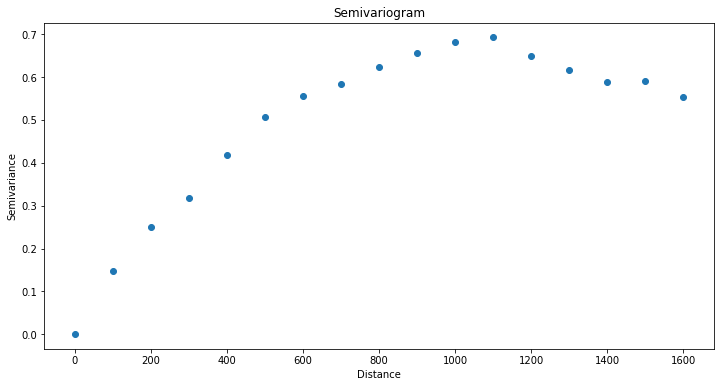

In [4]:
# Plot experimental semivariogram

plt.figure(figsize=(12, 6))
plt.plot(exp[:, 0], exp[:, 1], 'o')
plt.title('Semivariogram')
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

### 4. Semivariogram modeling: the fit of theoretical model

In [5]:
theo = TheoreticalSemivariogram(points_array=df.values, empirical_semivariance=exp)

In [6]:
# Params

number_of_rngs = len(exp)

In [7]:
opt_model = theo.find_optimal_model(number_of_ranges=number_of_rngs)
print(f'Optimal model is {opt_model}')

Optimal model is spherical


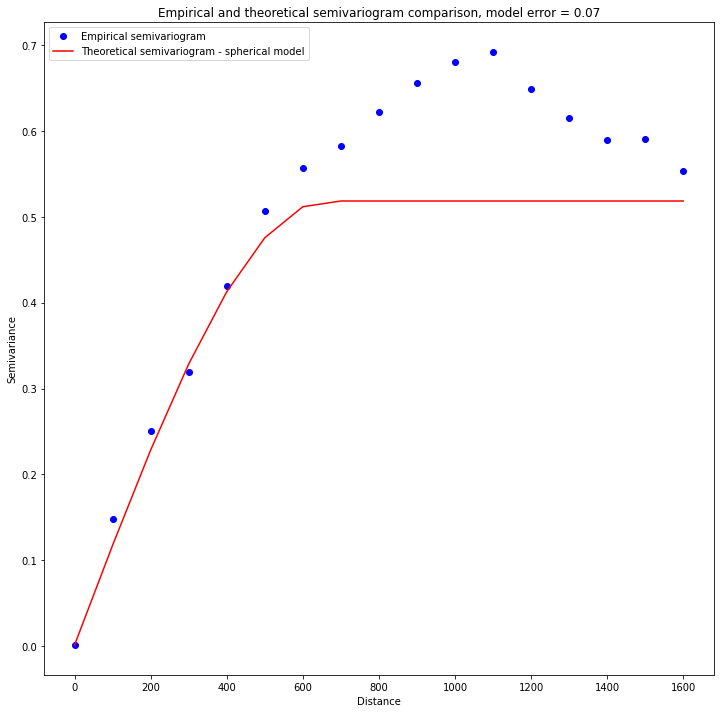

In [8]:
theo.show_semivariogram()

In [9]:
print('Calculted nugget:', theo.nugget)
print('Calculted sill:', theo.sill)
print('Calculted range:', theo.range)

Calculted nugget: 0.000890445502830676
Calculted sill: 0.5177502455179259
Calculted range: 662.5


### 5. Kriging: sanity check - unbiasedness

Kriging is an unbiased estimator which means that interpolated values at known locations are the same as measurements. In this step we check this property with random sample from measurements.

In [10]:
# Initialize Kriging model

model = Krige(semivariogram_model=theo, known_points=df.values)

In [11]:
unknown = df.sample().values[0]
unknown_val = unknown[-1]
unknown_loc = unknown[:-1]
nn = len(df.values) - 1

In [12]:
ok_pred = model.ordinary_kriging(unknown_location=unknown_loc,
                                 number_of_neighbours=nn)

In [13]:
ok_pred

(6.663132695990803,
 0.029840333490607572,
 0.0,
 array([ 1., -0., -0., -0.,  0.,  0., -0.,  0., -0., -0., -0.,  0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0.,  0.,  0.,  0., -0.,  0., -0., -0., -0.,
        -0., -0., -0.,  0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0.,  0.,  0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,  0.]))

In [14]:
ok_pred[0] == unknown_val

True

### 6. Kriging: interpolation

In [15]:
# Read point grid

data = pd.read_csv('meuse_grid.csv')
data = data[['x', 'y']].values

In [16]:
interpolated_results = []

for pt in data:
    try:
        pred, err = model.ordinary_kriging(unknown_location=pt,
                                           number_of_neighbours=nn)[:2]
    except ValueError:
        pred, err = np.nan, np.nan
    interpolated_results.append([pt[0], pt[1], pred, err])
    
predictions = pd.DataFrame(interpolated_results,
                           columns=['x', 'y', 'pyint.pred', 'pyint.err'])

In [17]:
predictions.head()

,x,y,pyint.pred,pyint.err
0,181180,333740,6.403158,0.335362
1,181140,333700,6.569880,0.299760
2,181180,333700,6.439625,0.306910
3,181220,333700,6.307948,0.248862
4,181100,333660,6.758722,0.235112


### 7. Comparison of interpolated results: statistics

In [18]:
# Read predictions from R

rpred = pd.read_csv('kriged.csv')
rpred.drop('Unnamed: 0', inplace=True, axis=1)

In [19]:
rpred.head()

,x,y,var1.pred,var1.var,optional
0,181180,333740,6.499618,0.319808,True
1,181140,333700,6.622352,0.252020,True
2,181180,333700,6.505162,0.272985,True
3,181220,333700,6.387586,0.295529,True
4,181100,333660,6.764491,0.177940,True


In [20]:
# Merge dataframes

merged = rpred.merge(predictions, on=['x', 'y'])
merged.dropna(inplace=True)

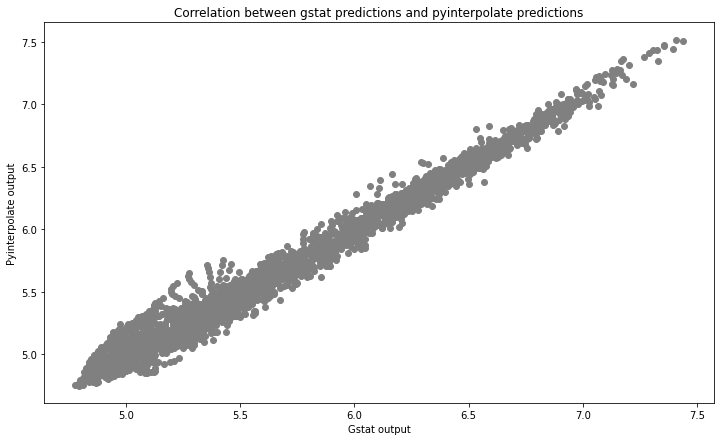

In [21]:
# Show scatterplots of predicted by pyinterpolate and gstat

plt.figure(figsize=(12, 7))
plt.scatter(merged['var1.pred'], merged['pyint.pred'], c='gray')
plt.title('Correlation between gstat predictions and pyinterpolate predictions')
plt.xlabel('Gstat output')
plt.ylabel('Pyinterpolate output')
plt.show()

In [22]:
# Pearson corr coefficient

pearsonr(merged['var1.pred'], merged['pyint.pred'])

(0.9896899174844275, 0.0)

### 8. Comparison of interpolated results: maps

In [23]:
# Transform data into GeoDataFrame

def df_to_geo(dataframe, lon_col='longitude', lat_col='latitude'):
    """Function transform longitude and latitude coordinates into GeoSeries.
    
    INPUT:
    
    :param dataframe: DataFrame to be transformed,
    :param lon_col: (str) longitude column name, default is 'longitude',
    :param lat_col: (str) latitude column name, default is 'latitude'.
    
    OUTPUT:
    
    :return: (GeoPandas GeoDataFrame)
    """

    # Transform lon / lat to points
    geometry = dataframe.apply(lambda x: Point([x[lon_col], x[lat_col]]), axis=1)
    geometry.name = 'geometry'
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(dataframe)
    gdf = gdf.join(geometry)
    
    return gdf

In [24]:
geo_df = df_to_geo(merged, 'x', 'y')

In [25]:
geo_df.head()

,x,y,var1.pred,var1.var,optional,pyint.pred,pyint.err,geometry
0,181180,333740,6.499618,0.319808,True,6.403158,0.335362,POINT (181180.000 333740.000)
1,181140,333700,6.622352,0.252020,True,6.569880,0.299760,POINT (181140.000 333700.000)
2,181180,333700,6.505162,0.272985,True,6.439625,0.306910,POINT (181180.000 333700.000)
3,181220,333700,6.387586,0.295529,True,6.307948,0.248862,POINT (181220.000 333700.000)
4,181100,333660,6.764491,0.177940,True,6.758722,0.235112,POINT (181100.000 333660.000)


<AxesSubplot:>

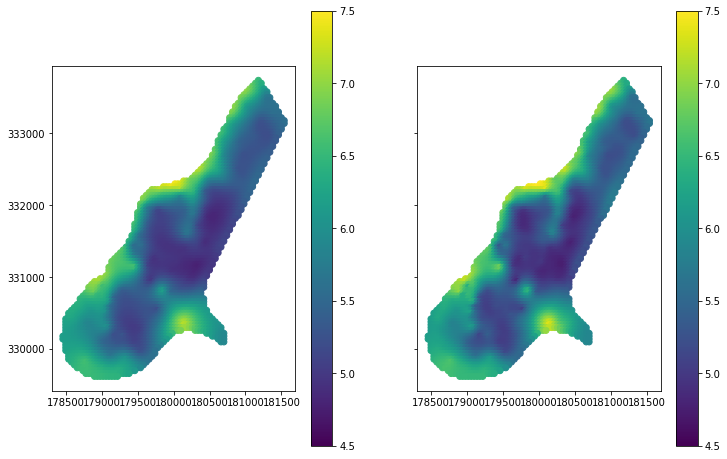

In [26]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12, 8))
geo_df.plot(ax=axes[0], column='var1.pred', legend=True, vmin=4.5, vmax=7.5)
geo_df.plot(ax=axes[1], column='pyint.pred', legend=True, vmin=4.5, vmax=7.5)

<AxesSubplot:>

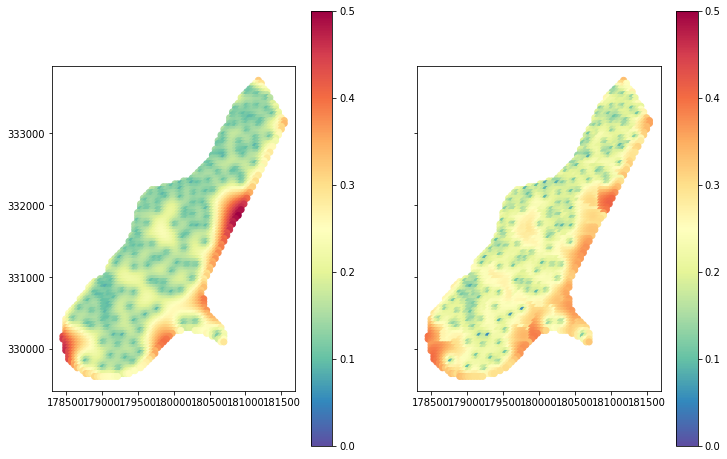

In [27]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12, 8))
geo_df.plot(ax=axes[0], column='var1.var', cmap='Spectral_r', legend=True, vmin=0, vmax=0.5)
geo_df.plot(ax=axes[1], column='pyint.err', cmap='Spectral_r', legend=True, vmin=0, vmax=0.5)

---